<a href="https://colab.research.google.com/github/tbolwerk/AGARIO/blob/master/dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

In [ ]:
%matplotlib inline
import numpy as np
import scipy.optimize
import sklearn.datasets
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

## 1.1 Gradient descent optimization

Consider the following function with two parameters and its derivatives:
\begin{align}
  f(x, y) &= x^2 + y^2 + x (y + 2) + \cos(3x) \\
  \frac{\partial f}{\partial x} &= 2x - 3\sin(3x) + y + 2 \\
  \frac{\partial f}{\partial y} &= x + 2y \\
\end{align}

In [ ]:
def f(x, y):
    return x ** 2 + y ** 2 + x * (y + 2) + np.cos(3 * x)
def grad_x_f(x, y):
    return 2 * x - 3 * np.sin(3 * x) + y + 2
def grad_y_f(x, y):
    return x + 2 * y

A plot of the function shows that it has multiple local minima:

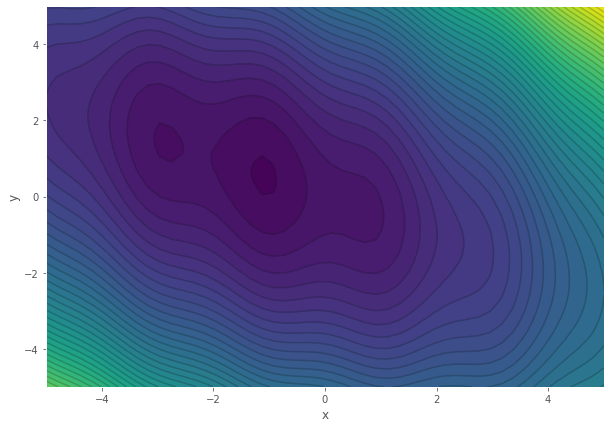

In [ ]:
def plot_f_contours():
    xx, yy = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
    zz = f(xx, yy)
    plt.contourf(xx, yy, zz, 50)
    plt.contour(xx, yy, zz, 50, alpha=0.2, colors='black', linestyles='solid')
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(10, 7))
plot_f_contours()

### Implement gradient descent

We would like to find the minimum of this function using gradient descent.

**Implement the gradient descent updates for $x$ and $y$ in the function below:**

In [ ]:
def optimize_f(x, y, step_size, steps):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y] # Weights

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at the current point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        # W: Weight, N: Learning rate, g_i gradient
        x = x - step_size * dx # W <- Wx - N * gx_i
        y = y - step_size * dy # W <- Wy - N * gy_i

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

### Tune the parameters

We will now try if our optimization method works.

Use this helper function to plot the results:

In [ ]:
# helper function that plots the results of the gradient descent optimization
def plot_gradient_descent_results(x, y, val, x_hist, y_hist):
    # plot the path on the contour plot
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plot_f_contours()
    plt.plot(x_hist, y_hist, '.-')

    # plot the learning curve
    plt.subplot(1, 2, 2)
    plt.plot(f(np.array(x_hist), np.array(y_hist)), '.r-')
    plt.title('Minimum value: %f' % f(x_hist[-1], y_hist[-1]))

**Run the gradient descent optimization with the following initial settings:**

``x=3, y=2, step_size=0.1, steps=10``

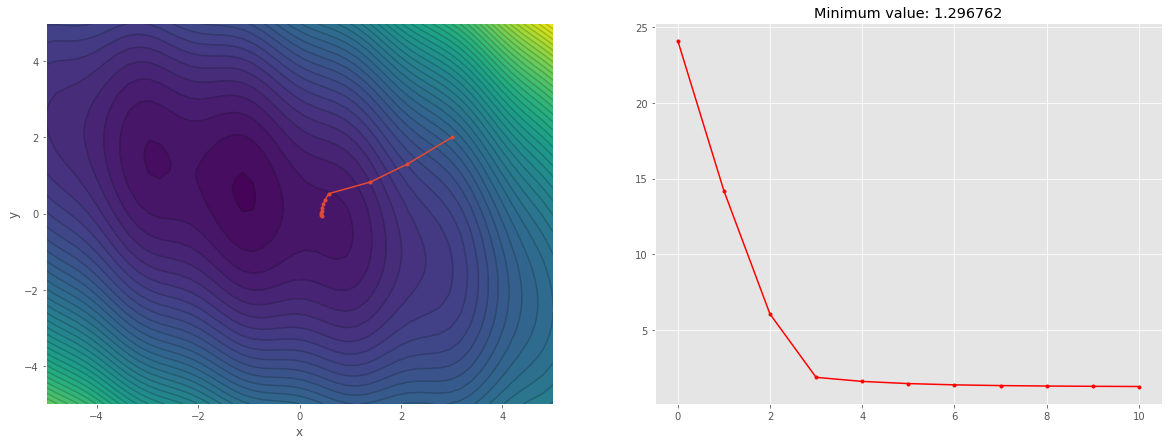

In [ ]:
results = optimize_f(x=3, y=2, step_size=0.1, steps=10)
plot_gradient_descent_results(*results)

**Does it find the minimum of the function? What happens?**

There are multiple local minima's, the optimize functions goes to one of the 3 local minima's

https://www.wolframalpha.com/input/?i=minimize+x%5E2%2By%5E2%2Bx*%28y%2B2%29%2Bcos%283*x%29

**Try a few different values for the `step_size` and the number of `steps` to get closes to the optimal solution:**

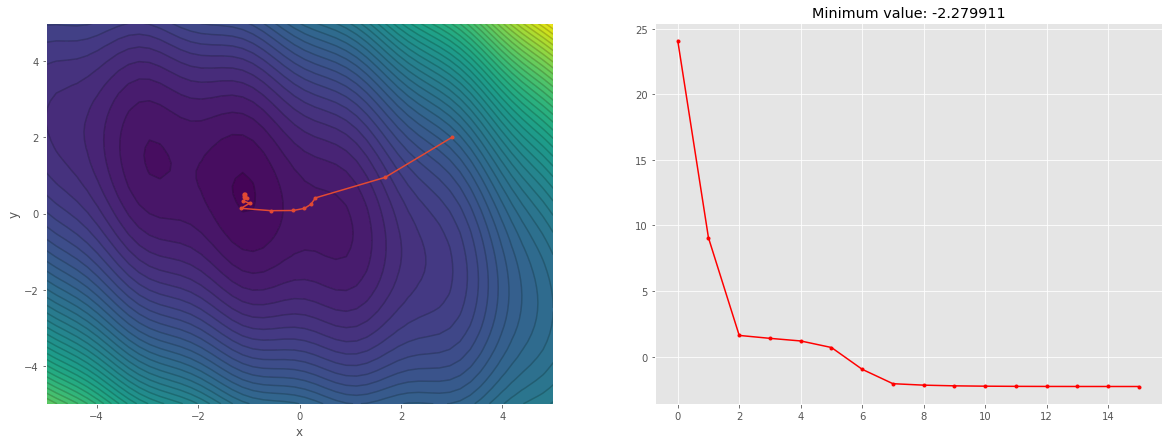

In [ ]:

results = optimize_f(x=3, y=2, step_size=0.15, steps=15)
plot_gradient_descent_results(*results)

**Were you able to find a step size that reached the global optimum? If not, why not?**

Yes we found the second global minima

### Implement a decreasing step size

You might get better results if you use a step size that is large at the beginning, but slowly decreases during the optimization.

Try the following scheme to compute the step size $\eta_t$ in step $t$, given a decay parameter $d$:
\begin{align}
  \eta_t = \eta_0 d^t
\end{align}

**Update your optimization function to use this step size schedule:**

In [ ]:
def optimize_f(x, y, step_size, steps, decay=1.0):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at this point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        nx = dx * step_size * decay ** steps
        ny = dy * step_size * decay ** steps

        # apply the gradient descent updates to x and y
        x = x - nx # Weight <- Weight - N * decay ^ step_size
        y = y - ny # Weight <- Weight - N * decay ^ step_size

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

**Tune the `step_sizes`, `steps` and `decay` parameters to get closer to the global minimum:**

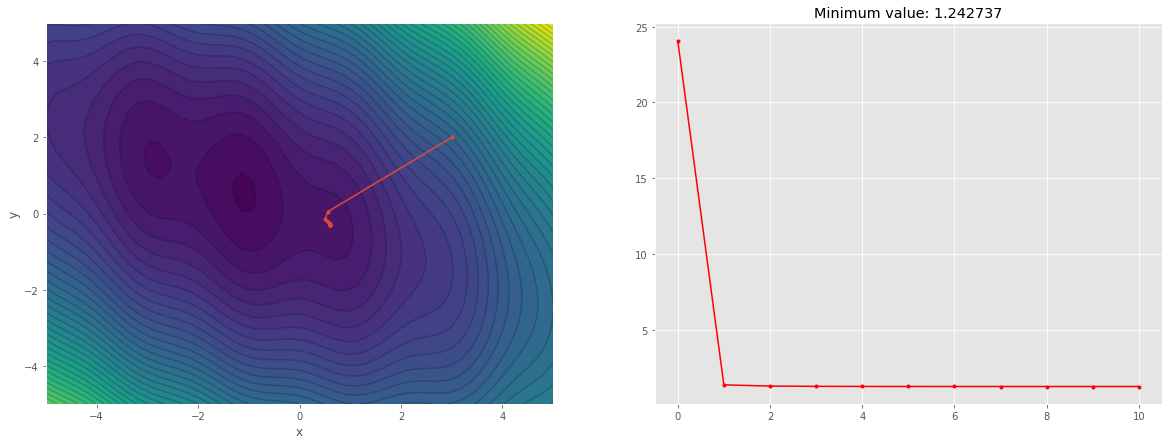

In [ ]:
results = optimize_f(x=3, y=2, step_size=0.8, steps=10, decay=0.9)
plot_gradient_descent_results(*results)

# Found the one of the local minimum with just 10 steps instead of 15, using the decay input



We will now look at some more complex functions that we can try to optimize.

## 1.2 Neural network components

In this assignment, we will implement a simple neural network from scratch. We need four components:
1. A sigmoid activation function,
2. A ReLU activation function,
3. A binary cross-entropy loss function,
4. A linear layer.

For each component, we will implement the forward pass, the backward pass, and the gradient descent update.

### Sigmoid non-linearity

The sigmoid function is defined as:

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\end{align}


**Give the derivative of the sigmoid function:**

We need to apply the chain rule on the sigmoid function.
\begin{align}
f'({g(x)}) * g'(x)
\end{align}
we are looking for the derivite of f.
\begin{align}
\sigma(x) (1 - \sigma)
\end{align}
rewrite sigmoid as:
\begin{align}
(1 + e^{-x})^{-1}  \\
u = v^{-1}\\
v = 1 + e^{-x} \\
\frac{dv}{dx} = -e^{-x} \\
\frac{du}{dx} = -v^{-2} * \frac{dv}{dx}\\
\end{align}
fill in the variables we just assigned (v and dv/dx):
\begin{align}
\frac{du}{dx} = -(1+e^{-x})^{-2} * (-e^{-x})\\
\end{align}

**Implement the sigmoid and its gradient in the functions `sigmoid(x)` and `sigmoid_grad(x)`:**

In [ ]:
def sigmoid(x):
     return 1 / (1 + np.exp(-1 * x))

def sigmoid_grad(x):
     return sigmoid(x)* (1 - sigmoid((x)))

def sigmoid_grad_2(x):
    return np.exp(-x) / (1 + np.exp(-x)) ** 2

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('sigmoid(x):', sigmoid(x))
print('sigmoid_grad(x):', sigmoid_grad(x))
print('sigmoid_grad_2(x):', sigmoid_grad_2(x))

x: [-7.623362 -6.338887 -4.89919   2.782311 -5.624749]
sigmoid(x): [0.000489 0.001763 0.007397 0.941712 0.003595]
sigmoid_grad(x): [0.000488 0.00176  0.007343 0.05489  0.003582]
sigmoid_grad_2(x): [0.000488 0.00176  0.007343 0.05489  0.003582]


To check that the gradient implementation is correct, we can compute the numerical derivative using the [finite difference](https://en.wikipedia.org/wiki/Finite_difference) method. From [Chapter 11.5 of the Deep Learning book](http://www.deeplearningbook.org/contents/guidelines.html):

> Because
  \begin{align}
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{ \epsilon},
  \end{align}
  we can approximate the derivative by using a small, finite $\epsilon$:
  \begin{align}
    f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}.
  \end{align}
  We can improve the accuracy of the approximation by using the centered difference:
  \begin{align}
    f'(x) \approx \frac{f(x + \frac{1}{2} \epsilon) - f(x - \frac{1}{2} \epsilon)}{\epsilon}.
  \end{align}
  The perturbation size $\epsilon$ must be large enough to ensure that the perturbation is not rounded down too much by ﬁnite-precision numerical computations.

**Use the central difference method to check your implementation of the sigmoid gradient. Compute the numerical gradient and check that it is close to the symbolic gradient computed by your implementation:**

In [ ]:
# start with some random inputs
x = np.random.uniform(-2, 2, size=5)

# compute the symbolic gradient
print('Symbolic', sigmoid_grad(x))

delta = 0.001
print('Numerical', ((sigmoid(x + delta) - sigmoid(x)) / delta))
print('Numerical more precise', ((sigmoid(x + 1/2 * delta) - sigmoid(x - 1/2 * delta)) / delta))

Symbolic [0.218988 0.190935 0.163717 0.188899 0.237026]
Numerical [0.219026 0.190888 0.163765 0.188852 0.237053]
Numerical more precise [0.218988 0.190935 0.163717 0.188899 0.237026]


**Is the gradient computed with finite differences exactly the same as the analytic answer? Why (not)?**

With the numberical precise approach we get idential results.

**If there is a visible difference between the two gradients, please try to make this as small as possible before you continue.**




## Rectified linear units (ReLU)

The rectified linear unit is defined as:
\begin{align}
  f(x) = \max(0, x)
\end{align}

![relu.png](attachment:relu.png)

**Give the derivative of the ReLU function:**

\begin{align}
  \frac{\partial f(x)}{\partial x} &= \begin{cases}
0 & \text{if } x < 0\\
1 & \text{if } x > 1\\
\end{cases}
\end{align}


**Implement the ReLU function and its gradient in the functions `relu(x)` and `relu_grad(x)`. Use the finite difference method to check that the gradient is correct:**

In [ ]:
def relu(x):
 return x * (x > 0)

def relu_grad(x):
  return (x * (x > 0)) * ((1/x) * (x > 1))

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('relu(x):', relu(x))
print('relu_grad(x):', relu_grad(x))

delta = 0.001
print('numerical:', (relu(x + delta) - relu(x)) /delta)


x: [-0.687675  9.293662 -8.280507 -7.703784 -3.99114 ]
relu(x): [-0.        9.293662 -0.       -0.       -0.      ]
relu_grad(x): [0. 1. 0. 0. 0.]
numerical: [0. 1. 0. 0. 0.]


### Comparing sigmoid and ReLU

The sigmoid and ReLU activation functions have slightly different characteristics.

**Run the code below to plot the sigmoid and ReLU activation functions and their gradients:**

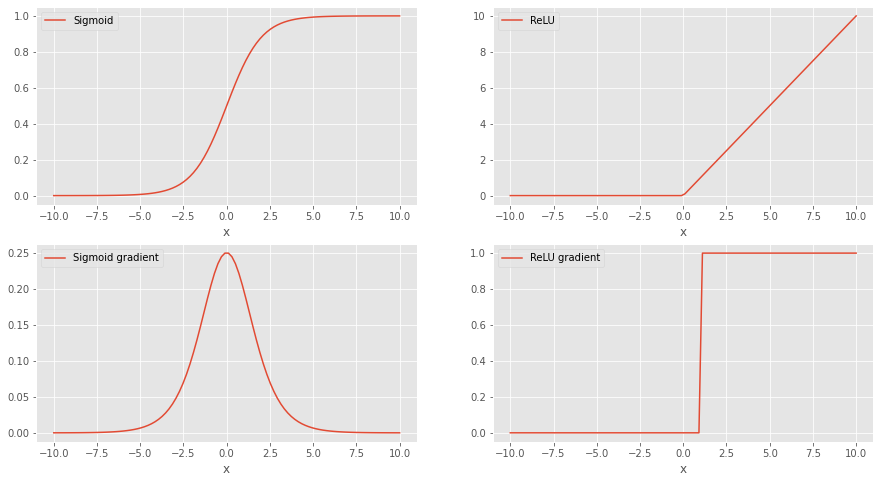

In [ ]:
x = np.linspace(-10, 10, 100)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='ReLU')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(x, sigmoid_grad(x), label='Sigmoid gradient')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(x, relu_grad(x), label='ReLU gradient')
plt.xlabel('x')
plt.legend(loc='upper left');

**Which activation function would you recommend for a network that outputs probabilities, i.e., outputs $\in (0, 1)$? Why?**

Relu is more linear than a sigmoid function, therefore the ReLu function is more ideal for this binary expected output.

**Compare the gradients for sigmoid and ReLU. What are the advantages and disadvantages of each activation function?**

Because ReLu result in 0 more often in reduces to a more sparse output. This can result in faster learning of the model.


### Binary cross-entropy loss

We will use the binary cross-entropy loss to train our network. This loss function is useful for binary classification.

The binary cross-entropy (BCE) is a function of the ground truth label $y \in \{0, 1\}$ and the predicted label $\hat{y} \in (0, 1)$:

\begin{align}
  \mathcal{L} &= -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
\end{align}

To minimize the BCE loss with gradient descent, we need to compute the gradient with respect to the prediction $\hat{y}$.

**Derive the gradient for the BCE loss:**



\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{y}} &= \frac{\hat{y} - y}{\hat{y} (1 - \hat{y})}
\end{align}


**Implement `bce_loss(y, y_hat)` and `bce_loss_grad(y, y_hat)` and use the finite difference method to check that the gradient is correct:**

In [ ]:
def bce_loss(y, y_hat):
    return -1 * (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

def bce_loss_grad(y, y_hat):
    return (y_hat - y) / (y_hat * (1 - y_hat))

# try with some random inputs
y = np.random.randint(2, size=5)
y_hat = np.random.uniform(0, 1, size=5)
print('y:', y)
print('y_hat:', y_hat)
print('bceloss(y, y_hat):', bce_loss(y, y_hat))
print('bceloss_grad(y,y_hat):', bce_loss_grad(y,y_hat))
print('numerical:', ((bce_loss(y,y_hat + delta) - bce_loss(y, y_hat)) / delta))
print('numerical:', ((bce_loss(y,y_hat + (1/2 * delta)) - bce_loss(y, y_hat - (1/2 * delta))) / delta))



y: [0 0 1 1 0]
y_hat: [0.872876 0.47678  0.488259 0.759039 0.253963]
bceloss(y, y_hat): [2.06259  0.647752 0.71691  0.275702 0.29298 ]
bceloss_grad(y,y_hat): [ 7.86632   1.91124  -2.048095 -1.317456  1.340416]
numerical: [ 7.897423  1.913069 -2.046001 -1.316589  1.341315]
numerical: [ 7.866361  1.911241 -2.048096 -1.317456  1.340416]


### Linear layer

Finally, we need to compute the gradients for the linear layer in our network.

Define a linear model $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$, where
* $\mathbf{x}$ is an input vector of shape $N$,
* $\mathbf{W}$ is a weight matrix of shape $N \times M$,
* $\mathbf{b}$ is a bias vector of shape $M$,
* $\mathbf{y}$ is the output vector of shape $M$.

**Derive the gradients for $\mathbf{y}$ with respect to the input $\mathbf{x}$ and the parameters $\mathbf{W}$ and $\mathbf{b}$:**

_Hint: If you have trouble computing this in matrix notation directly, try to do the computation with scalars first._

\begin{align}
  \nabla_\mathbf{x} \mathbf{y} = \sum^{M}_{i=1} \sum^{N}_{j=1} \frac{\partial \mathbf{y_i}}{\partial \mathbf{x_j}} \big[\mathbf{x_j} \mathbf{W_{j,i}} + \mathbf{b} \big] =  \sum^{M}_{i=1} \sum^{N}_{j=1} \frac{\partial \mathbf{y_i}}{\partial \mathbf{x_j}} \big[\mathbf{x_j} \mathbf{W_{j,i}}  \big] \text{search for pattern in } x_1= \sum^{M}_{i=1}\frac{\partial y_i}{\partial x_1} \big[\mathbf{x}_1\mathbf{W_{1,i}} + .. + \mathbf{x}_N\mathbf{W_{N,i}}\big] = \sum^{M}_{i=1} \frac{\partial y_i}{\partial x_1} \big[\mathbf{x}_1 \mathbf{W_{1,i}}\big] + 0 .. + 0 = 1 * \mathbf{W_{1,i}} = \mathbf{W_{1,i}} = \text{and therefore } \mathbf{W_{j,i}} = \mathbf{W}
  \end{align}
  \begin{align}
  \nabla_\mathbf{W} \mathbf{y} = \frac{\partial \mathbf{y}}{\partial \mathbf{W}} &= \sum^{M}_{i=1} \sum^{N}_{j=1} \frac{\partial \mathbf{y_i}}{\partial \mathbf{W_{j,i}}} \big[\mathbf{x_j} \mathbf{W_{j,i}} + \mathbf{b} \big] = \text{search for pattern in } \mathbf{W_{1,i}} = \sum^{M}_{i=1}\frac{\partial y_i}{\partial \mathbf{W_{1,i}}} \big[\mathbf{x}_1\mathbf{W_{1,i}} + .. + \mathbf{x}_N\mathbf{W_{N,i}}\big] = \sum^{M}_{i=1} \frac{\partial y_i}{\partial \mathbf{W_{1,i}}} \big[\mathbf{x}_1\mathbf{W_{1,i}} \big] + .. + \mathbf{x_N} * 0 =  \sum^{M}_{i=1} \frac{\partial y_i}{\partial \mathbf{W_{1,i}}} \big[\mathbf{x}_1\mathbf{W_{1,i}} \big] = x_1 \text{and therefore} = \sum^{M}_{i=1} \sum^{N}_{j=1} x_j = x \end{align}
\begin{align}
  \nabla_\mathbf{b} \mathbf{y} &= \frac{\partial \mathbf{y}}{\partial \mathbf{b}} = \sum^{M}_{i=1} \sum^{N}_{j=1} \frac{\partial \mathbf{y_i}}{\partial \mathbf{x_j}} \big[\mathbf{x_j} \mathbf{W_{j,i}} + \mathbf{b} \big] = 0 + 1 = 1\\
\end{align}


**Given the gradient $\nabla_\mathbf{y} \mathcal{L}$ for the loss w.r.t. $\mathbf{y}$, use the chain rule to derive the gradients for the loss w.r.t. $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$:**



\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \nabla_y\mathcal{L} W^T\\
  \nabla_\mathbf{W} \mathcal{L} &= \nabla_y\mathcal{L} x\\
  \nabla_\mathbf{b} \mathcal{L} &= \nabla_y\mathcal{L}\\
\end{align}


## 1.3 Implement a one-layer model

We can now implement a simple one-layer model with a sigmoid activation:

1. Given an input vector $\mathbf{x}$, weight vector $\mathbf{w}$ and bias $b$, compute the output $\hat{y}$:

\begin{align}
h = \mathbf{x}^T \mathbf{w} + b \\
\hat{y} = \sigma(h) \\
\end{align}

2. Compute the BCE loss comparing the prediction $\hat{y}$ with the ground-truth label $y$.

3. Compute the gradient for the BCE loss and back-propagate this to get $\nabla_\mathbf{x} \mathcal{L}$, the gradient of $\mathcal{L}$ w.r.t. $\mathbf{x}$.

**Complete the implementation below:**


Personal note on how to do backward pass:
\begin{align}
\nabla_{\hat y}\mathcal{L} = \frac{\partial \mathcal{L}}{\partial \hat y} \\
\nabla_{h}\mathcal{L} = \frac{\partial \mathcal{L}}{\partial \hat y} \cdot \frac{\partial \mathcal{L}}{\partial h}\\
\nabla_{x} \mathcal{L} = \frac{\partial \mathcal{L}}{\partial \hat y} \cdot \frac{\partial \mathcal{L}}{\partial h} \cdot \frac{\partial \mathcal{L}}{\partial x}
\end{align}

In [ ]:
# initialize parameters
w = np.random.uniform(size=5)
b = np.random.rand()

# implement the model
def fn(x, y):

    h = np.dot(np.transpose(x), w) + b
    y_hat = sigmoid(h)
    loss = bce_loss(y, y_hat)


    grad_y_hat = bce_loss_grad(y, y_hat)  # dL/dy^
    grad_h = np.dot(grad_y_hat, sigmoid_grad(h)) # grad_h = dL/dy^ *
    grad_x = np.dot(grad_h, np.transpose(w))

    return loss, grad_x

# test with a random input
x = np.random.uniform(size=5)
y = 1

loss, grad_x = fn(x, y)
print("Loss", loss)
print("Gradient", grad_x)

Loss 0.16964412100063217
Gradient [-0.123135 -0.143681 -0.063789 -0.117378 -0.144279]


**Use the finite-difference method to check the gradient $\nabla_\mathbf{x} \mathcal{L}$:**

In [ ]:
# start with some random inputs
x = np.random.uniform(size=5)
y = 1

# set epsilon to a small value
eps = 0.00001

numerical_grad = np.zeros(x.shape)

# compute the gradient for each element of x separately
for i in range(len(x)):
    # compute inputs at -eps/2 and +eps/2
    x_a, x_b = x.copy(), x.copy()
    x_a[i] += eps / 2
    x_b[i] -= eps / 2

    # compute the gradient for this element
    loss_a, _ = fn(x_a, y)
    loss_b, _ = fn(x_b, y)
    numerical_grad[i] = (loss_a - loss_b) / eps


# compute the symbolic gradient
loss, symbolic_grad = fn(x, y)

print("Symbolic gradient")
print(symbolic_grad)
print("Numerical gradient")
print(numerical_grad)


Symbolic gradient
[-0.051884 -0.060541 -0.026878 -0.049458 -0.060793]
Numerical gradient
[-0.051884 -0.060541 -0.026878 -0.049458 -0.060793]


## 1.4 Implement a linear layer and the sigmoid and ReLU activation functions

We will now construct a simple neural network. We need to implement the folowing objects:
* `Linear`: a layer that computes `y = x*W + b`.
* `Sigmoid`: a layer that computes `y = sigmoid(x)`.
* `ReLU`: a layer that computes `y = relu(x)`.

For each layer class, we need to implement the following methods:
* `forward`: The forward pass that computes the output `y` given `x`.
* `backward`: The backward pass that receives the gradient for `y` and computes the gradients for the input `x` and the parameters of the layer.
* `step`: The update step that applies the gradient updates to the parameters of the layer, based on the gradient computed and stored by `backward`.

**Implement a class `Linear` that computes `y = x*W + b`:**

In [ ]:
# Computes y = x * w + b.
class Linear:
    def __init__(self, n_in, n_out):
        # initialize the weights randomly,
        # using the Xavier initialization rule for scale
        a = np.sqrt(6 / (n_in * n_out))
        self.W = np.random.uniform(-a, a, size=(n_in, n_out))
        self.b = np.zeros((n_out,))

    def forward(self, x):
        # y = x * W + b
        y = np.dot(x, self.W) + self.b
        return y

    def backward(self, x, dy):
        # given dy, compute the gradients for x, W and b
        dx = np.dot(dy ,np.transpose(self.W))  # dy/dx * dW/dy
        self.dW = np.dot(np.transpose(x), dy)  # dx^T/dy * dy/dx
        self.db = np.sum(np.dot(1, dy), axis=0, keepdims=False)
        return dx

    def step(self, step_size):

        self.W = self.W - step_size * self.dW
        self.b = self.b - step_size * self.db

    def __str__(self):
        return 'Linear %dx%d' % self.W.shape


# Try the new class with some random values.
# Debugging tip: always choose a unique length for each
# dimension, so you'll get an error if you mix them up.
x = np.random.uniform(size=(3, 5))

layer = Linear(5, 7)
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[-0.012411 -0.164363 -0.202116  0.399013 -0.179896 -0.078611 -0.342673]
 [ 0.147948 -0.123523 -0.026613  0.247009 -0.067481  0.144286 -0.125594]
 [ 0.188434  0.018262  0.119659  0.005983 -0.19209   0.203583  0.143468]]
dx: [[-0.772977  0.256835 -0.222292 -0.013367  1.017045]
 [-0.772977  0.256835 -0.222292 -0.013367  1.017045]
 [-0.772977  0.256835 -0.222292 -0.013367  1.017045]]


**Implement a class `Sigmoid` that computes `y = 1 / (1 + exp(-x))`:**

In [ ]:
# Computes y = 1 / (1 + exp(-x)).
class Sigmoid:
    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        return y

    def backward(self, x, dy):
        # return the gradient for x given dy
        dx = 1 / (1 + np.exp(-x)) *(1-1 / (1 + np.exp(-x)))
        return dx * dy

    def step(self, step_size):
        pass

    def __str__(self):
        return 'Sigmoid'


# try the new class with some random values
x = np.random.uniform(size=(3, 5))

layer = Sigmoid()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[0.553917 0.625066 0.636083 0.663155 0.537148]
 [0.628638 0.726823 0.633483 0.511641 0.508745]
 [0.610774 0.730128 0.63099  0.71412  0.689247]]
dx: [[0.247093 0.234358 0.231481 0.22338  0.24862 ]
 [0.233452 0.198551 0.232182 0.249864 0.249924]
 [0.237729 0.197041 0.232842 0.204153 0.214186]]


**Implement a class `ReLU` that computes `y = max(0, x)`:**

In [ ]:
# Computes y = max(0, x).
class ReLU:
    def forward(self, x):
        y = np.maximum(0, x)
        return y

    def backward(self, x, dy):
        # return the gradient for x given dy
        dx = dy * np.heaviside(x, 0)
        return dx

    def step(self, step_size):
        pass
    def __str__(self):
        return 'ReLU'


# try the new class with some random values
x = np.random.uniform(-10, 10, size=(3, 5))

layer = ReLU()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[4.581519 4.990548 0.       7.409998 3.551246]
 [0.       0.       0.       8.069648 0.      ]
 [0.       0.       0.833147 4.949494 0.      ]]
dx: [[1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0.]]


### Verify the gradients (using provided code)

The code below will check your implementations using SciPy's finite difference implementation [`check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html). This is similar to what we did manually before, but automates some of the work.

**Run the code and check that the error is not too large.**

In [ ]:
## Verify gradient computations for Linear
# test for dx
layer = Linear(5, 7)
def test_fn(x):
    x = x.reshape(3, 5)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    x = x.reshape(3, 5)
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones((3, 7))).flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=3 * 5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for dW
x = np.random.uniform(size=(3, 5))
layer = Linear(5, 7)
def test_fn(w):
    layer.W = w.reshape(5, 7)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(w):
    layer.W = w.reshape(5, 7)
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((3, 7)))
    return layer.dW.flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5 * 7))
print("err on dW:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for db
x = np.random.uniform(size=(3, 5,))
layer = Linear(5, 7)
def test_fn(b):
    layer.b = b
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(b):
    layer.b = b
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((x.shape[0], 7)))
    return layer.db

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=7))
print("err on db:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 6.284014557592648e-07
err on dW: OK 4.588124981690114e-06
err on db: OK 0.0


In [ ]:
## Verify gradient computation for Sigmoid
# test for dx
layer = Sigmoid()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return np.sum(2 * layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 5.680407458929641e-08


In [ ]:
## Verify gradient computation for ReLU
# test for dx
layer = ReLU()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(1, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 0.0


## 1.5 Construct a neural network with back-propagation

We will use the following container class to implement the network:
1. The `forward` pass computes the output of each layer. We store the intermediate inputs for the backward pass.
2. The `backward` pass computes the gradients for each layer, in reverse order, by using the original input `x` and the gradient `dy` from the previous layer.
3. The `step` function will ask each layer to apply the gradient descent updates to its weights.

**Read the code below:**

In [ ]:
class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

## 1.6 Training the network

We load a simple dataset with 360 handwritten digits.

Each sample has $8 \times 8$ pixels, arranged as a 1D vector of 64 features.

We create a binary classification problem with the label 0 for the digits 0 to 4, and 1 for the digits 5 to 9.

digits_x.shape: (1797, 64)
digits_y.shape: (1797,)
min, max values: -0.8117561971974786 1.847470154168513
labels: [0. 1.]


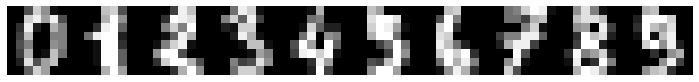

In [ ]:
# load the first two classes of the digits dataset
dataset = sklearn.datasets.load_digits()
digits_x, digits_y = dataset['data'], dataset['target']

# create a binary classification problem
digits_y = (digits_y < 5).astype(float)

# plot some of the digits
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([digits_x[i].reshape(8, 8) for i in range(10)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')

# normalize the values to [0, 1]
digits_x -= np.mean(digits_x)
digits_x /= np.std(digits_x)

# print some statistics
print('digits_x.shape:', digits_x.shape)
print('digits_y.shape:', digits_y.shape)
print('min, max values:', np.min(digits_x), np.max(digits_x))
print('labels:', np.unique(digits_y))

We divide the dataset in a train and a test set.

In [ ]:
# make a 50%/50% train/test split
train_prop = 0.5
n_train = int(digits_x.shape[0] * train_prop)

# shuffle the images
idxs = np.random.permutation(digits_x.shape[0])

# take a subset
x = {'train': digits_x[idxs[:n_train]],
     'test':  digits_x[idxs[n_train:]]}
y = {'train': digits_y[idxs[:n_train]],
     'test':  digits_y[idxs[n_train:]]}

print('Training samples:', x['train'].shape[0])
print('Test samples:', x['test'].shape[0])

Training samples: 898
Test samples: 899


We will now implement a function that trains the network. For each epoch, it loops over all minibatches in the training set and updates the network weights. It will then compute the loss and accuracy for the test samples. Finally, it will plot the learning curves.

**Read through the code below.**

In [ ]:
def fit(net, x, y, epochs=25, learning_rate=0.001, mb_size=10):
    # initialize the loss and accuracy history
    loss_hist = {'train': [], 'test': []}
    accuracy_hist = {'train': [], 'test': []}

    for epoch in range(epochs):
        # initialize the loss and accuracy for this epoch
        loss = {'train': 0.0, 'test': 0.0}
        accuracy = {'train': 0.0, 'test': 0.0}

        # first train on training data, then evaluate on the test data
        for phase in ('train', 'test'):
            # compute the number of minibatches
            steps = x[phase].shape[0] // mb_size

            # loop over all minibatches
            for step in range(steps):
                # get the samples for the current minibatch
                x_mb = x[phase][(step * mb_size):((step + 1) * mb_size)]
                y_mb = y[phase][(step * mb_size):((step + 1) * mb_size), None]

                # compute the forward pass through the network
                pred_y, trace = net.forward(x_mb)

                # compute the current loss and accuracy
                loss[phase] += np.mean(bce_loss(y_mb, pred_y))
                accuracy[phase] += np.mean((y_mb > 0.5) == (pred_y > 0.5))

                # only update the network in the training phase
                if phase == 'train':
                    # compute the gradient for the loss
                    dy = bce_loss_grad(y_mb, pred_y)

                    # backpropagate the gradient through the network
                    net.backward(trace, dy)

                    # update the weights
                    net.step(learning_rate)

            # compute the mean loss and accuracy over all minibatches
            loss[phase] = loss[phase] / steps
            accuracy[phase] = accuracy[phase] / steps

            # add statistics to history
            loss_hist[phase].append(loss[phase])
            accuracy_hist[phase].append(accuracy[phase])

        print('Epoch %3d: loss[train]=%7.4f  accuracy[train]=%7.4f  loss[test]=%7.4f  accuracy[test]=%7.4f' %
              (epoch, loss['train'], accuracy['train'], loss['test'], accuracy['test']))

    # plot the learning curves
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    for phase in loss_hist:
        plt.plot(loss_hist[phase], label=phase)
    plt.title('BCE loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    for phase in accuracy_hist:
        plt.plot(accuracy_hist[phase], label=phase)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

We will define a two-layer network:
* A linear layer that maps the 64 features of the input to 32 features.
* A ReLU activation function.
* A linear layer that maps the 32 features to the 1 output features.
* A sigmoid activation function that maps the output to [0, 1].

**Train the network and inspect the results. Tune the hyperparameters to get a good result.**

Epoch   0: loss[train]= 0.4160  accuracy[train]= 0.8192  loss[test]= 0.3115  accuracy[test]= 0.8644
Epoch   1: loss[train]= 0.2307  accuracy[train]= 0.9164  loss[test]= 0.1759  accuracy[test]= 0.9480
Epoch   2: loss[train]= 0.1556  accuracy[train]= 0.9469  loss[test]= 0.1302  accuracy[test]= 0.9661
Epoch   3: loss[train]= 0.1136  accuracy[train]= 0.9616  loss[test]= 0.1091  accuracy[test]= 0.9684
Epoch   4: loss[train]= 0.0876  accuracy[train]= 0.9740  loss[test]= 0.0967  accuracy[test]= 0.9672
Epoch   5: loss[train]= 0.0709  accuracy[train]= 0.9797  loss[test]= 0.0891  accuracy[test]= 0.9718
Epoch   6: loss[train]= 0.0589  accuracy[train]= 0.9831  loss[test]= 0.0854  accuracy[test]= 0.9718
Epoch   7: loss[train]= 0.0493  accuracy[train]= 0.9853  loss[test]= 0.0816  accuracy[test]= 0.9740
Epoch   8: loss[train]= 0.0422  accuracy[train]= 0.9876  loss[test]= 0.0794  accuracy[test]= 0.9740
Epoch   9: loss[train]= 0.0370  accuracy[train]= 0.9887  loss[test]= 0.0780  accuracy[test]= 0.9751


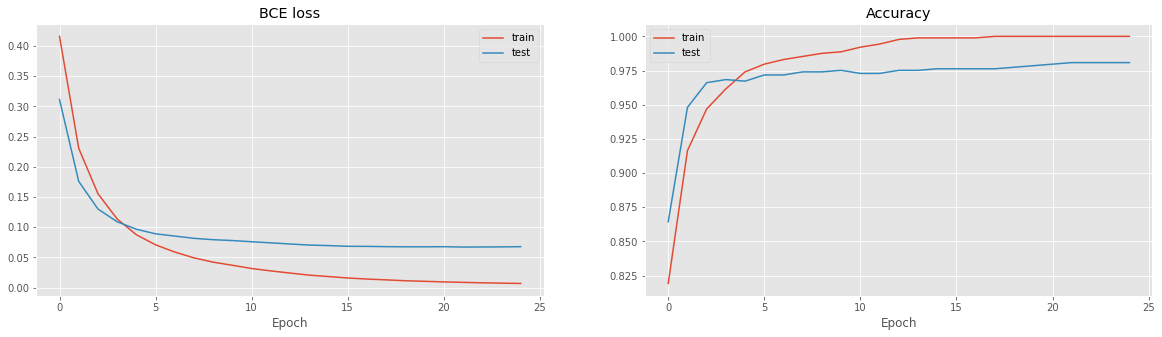

In [ ]:
# construct network
net = Net([
        Linear(64, 32),
        ReLU(),
        Linear(32, 1),
        Sigmoid()])


fit(net, x, y,
    epochs = 25,
    learning_rate = 0.01,
    mb_size = 15)


**Which of the hyperparameters (number of epochs, learning rate, minibatch size) was most important? How did they influence your results?**

The learning rate is by far the biggest contributer, for the most accurate result. The learning rate has a specific sweetspot with a few decimal points. Seems like if we make the learning rate too small it is not going anywhere and when the learning rate is to high it tends to overshoot itself.

**Repeat the experiment with a the same network, but remove the ReLU activation in the middle: `[Linear, Linear, Sigmoid]`.**

Epoch   0: loss[train]= 0.4371  accuracy[train]= 0.7966  loss[test]= 0.3146  accuracy[test]= 0.8820
Epoch   1: loss[train]= 0.3353  accuracy[train]= 0.8618  loss[test]= 0.2881  accuracy[test]= 0.8921
Epoch   2: loss[train]= 0.3116  accuracy[train]= 0.8742  loss[test]= 0.2781  accuracy[test]= 0.8921
Epoch   3: loss[train]= 0.2990  accuracy[train]= 0.8809  loss[test]= 0.2736  accuracy[test]= 0.8899
Epoch   4: loss[train]= 0.2910  accuracy[train]= 0.8831  loss[test]= 0.2715  accuracy[test]= 0.8944
Epoch   5: loss[train]= 0.2856  accuracy[train]= 0.8854  loss[test]= 0.2705  accuracy[test]= 0.8921
Epoch   6: loss[train]= 0.2816  accuracy[train]= 0.8820  loss[test]= 0.2700  accuracy[test]= 0.8921
Epoch   7: loss[train]= 0.2785  accuracy[train]= 0.8876  loss[test]= 0.2698  accuracy[test]= 0.8966
Epoch   8: loss[train]= 0.2761  accuracy[train]= 0.8921  loss[test]= 0.2697  accuracy[test]= 0.8966
Epoch   9: loss[train]= 0.2741  accuracy[train]= 0.8955  loss[test]= 0.2696  accuracy[test]= 0.8966


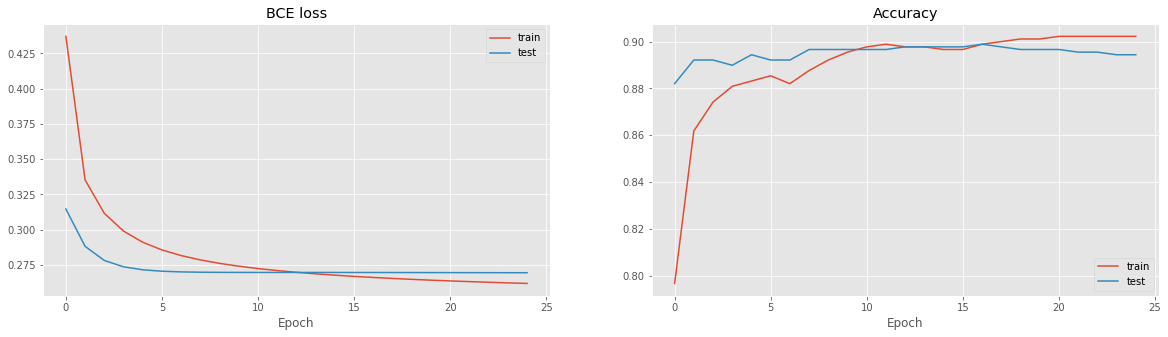

In [ ]:
# construct network
net = Net([
        Linear(64, 32),
        Linear(32, 1),
        Sigmoid()])


fit(net, x, y,
    epochs = 25,
    learning_rate = 0.01,
    mb_size = 10)


**How does the performance of this network compare with the previous network. Can you explain this result? How does removing the ReLU affect the model?**

It's less accurate, it went from .97 to .87 accuracy, the loss function with respect too the test data, seems to stabilize around 0.325, instead of 0.08 in the network with ReLu. By removing the ReLu, we are making the model less susceptable for changes with regards of the weights.

**Create a network with one linear layer followed by a sigmoid activation:**

`net = Net([Linear(...), Sigmoid()]`

**Train this network. Compare the results with the `[Linear, ReLU, Linear, Sigmoid]` and `[Linear, Linear, Sigmoid]` networks you trained before, and explain the results.**

Epoch   0: loss[train]= 0.4822  accuracy[train]= 0.7663  loss[test]= 0.3668  accuracy[test]= 0.8640
Epoch   1: loss[train]= 0.3432  accuracy[train]= 0.8685  loss[test]= 0.3235  accuracy[test]= 0.8876
Epoch   2: loss[train]= 0.3147  accuracy[train]= 0.8787  loss[test]= 0.3045  accuracy[test]= 0.8910
Epoch   3: loss[train]= 0.2998  accuracy[train]= 0.8865  loss[test]= 0.2933  accuracy[test]= 0.8933
Epoch   4: loss[train]= 0.2903  accuracy[train]= 0.8910  loss[test]= 0.2861  accuracy[test]= 0.8921
Epoch   5: loss[train]= 0.2838  accuracy[train]= 0.8910  loss[test]= 0.2811  accuracy[test]= 0.8921
Epoch   6: loss[train]= 0.2790  accuracy[train]= 0.8888  loss[test]= 0.2776  accuracy[test]= 0.8921
Epoch   7: loss[train]= 0.2755  accuracy[train]= 0.8910  loss[test]= 0.2751  accuracy[test]= 0.8933
Epoch   8: loss[train]= 0.2727  accuracy[train]= 0.8933  loss[test]= 0.2733  accuracy[test]= 0.8921
Epoch   9: loss[train]= 0.2705  accuracy[train]= 0.8944  loss[test]= 0.2719  accuracy[test]= 0.8933


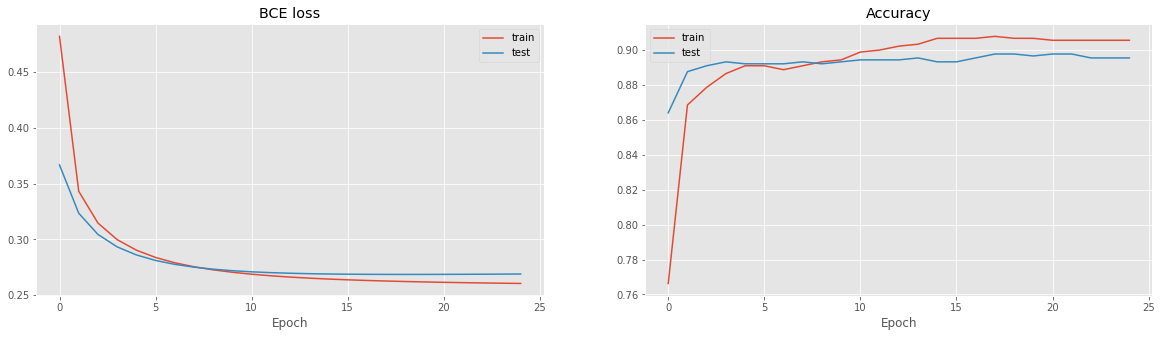

In [ ]:
# construct network
net = Net([
        Linear(64, 1),
        Sigmoid()])


fit(net, x, y,
    epochs = 25,
    learning_rate = 0.01,
    mb_size = 10)

**Discuss your results.**

There is almost no improvement in the accuracy, also the loss function is stabilizing much faster, for both the test and training data.

The complexer our input data, the more different layers we could use in finding the minima's for these multidimensional input data.

But there has been done some research and there is also a sweetspot for how many layers actually improve the accuracy of the model.

**Try a deeper network (e.g., four linear layers) to see if this can improve the results further.**

Epoch   0: loss[train]= 0.5534  accuracy[train]= 0.7169  loss[test]= 0.3516  accuracy[test]= 0.8640
Epoch   1: loss[train]= 0.3601  accuracy[train]= 0.8506  loss[test]= 0.2990  accuracy[test]= 0.8910
Epoch   2: loss[train]= 0.3228  accuracy[train]= 0.8742  loss[test]= 0.2842  accuracy[test]= 0.8978
Epoch   3: loss[train]= 0.3063  accuracy[train]= 0.8764  loss[test]= 0.2776  accuracy[test]= 0.8955
Epoch   4: loss[train]= 0.2964  accuracy[train]= 0.8798  loss[test]= 0.2744  accuracy[test]= 0.8944
Epoch   5: loss[train]= 0.2897  accuracy[train]= 0.8865  loss[test]= 0.2727  accuracy[test]= 0.8921
Epoch   6: loss[train]= 0.2850  accuracy[train]= 0.8854  loss[test]= 0.2718  accuracy[test]= 0.8921
Epoch   7: loss[train]= 0.2814  accuracy[train]= 0.8865  loss[test]= 0.2713  accuracy[test]= 0.8966
Epoch   8: loss[train]= 0.2786  accuracy[train]= 0.8854  loss[test]= 0.2711  accuracy[test]= 0.8966
Epoch   9: loss[train]= 0.2764  accuracy[train]= 0.8888  loss[test]= 0.2709  accuracy[test]= 0.8989


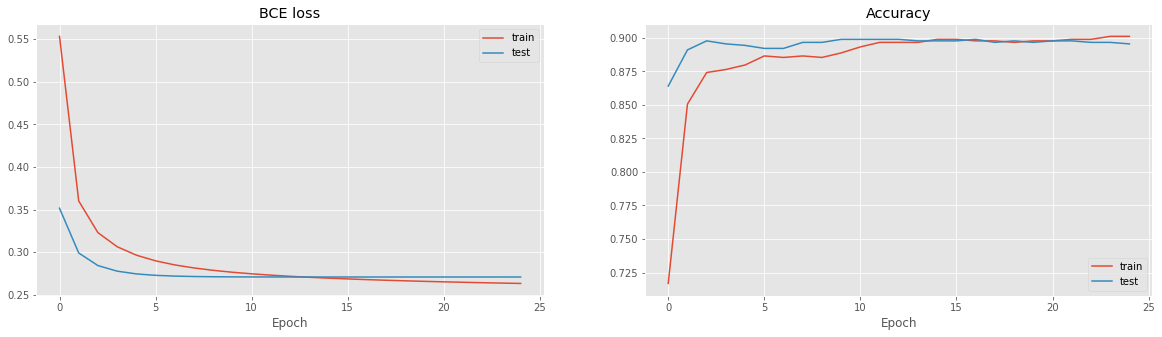

In [ ]:
# construct network
net = Net([
        Linear(64, 32),
        Linear(32, 16),
        Linear(16, 8),
        Linear(8,1),
        Sigmoid()])


fit(net, x, y,
    epochs = 25,
    learning_rate = 0.01,
    mb_size = 10)


**Discuss your findings. Were you able to obtain a perfect classification? Explain the learning curves.**

The best learning curve was actually achieved by the first netork with:
  Linear(64, 32),
  ReLU(),
  Linear(32, 1),
  Sigmoid()])

I think this is achieved by using multiple derivitives on a complex input dataset.

In order to get an even more accurate model we need more training data.

## 1.7 Final questions

You now have some experience training neural networks. Time for a few final questions.

**What is the influence of the learning rate? What happens if the learning rate is too low or too high?**

By reducing the learningrate the model will change more often with smaller amounts, resulting in lesser change of the model. Which will require us to do more epoch. If the learning rate is too small we run the risk for our model to get stuck.

By increasing the learning rate to much will cause the model to converge too fast and the model will settle on a suboptimal solution.

**What is the role of the minibatch size in SGD? Explain the downsides of a minibatch size that is too small or too high.**

Its the number of samples used for our input in the model. In reduces the training time of our model significantly and is often a neccesity in larger data sets. It updates more often and can increase the accuracy faster.

Make the minibatch size to large and the model won't learn at all, it needs to update it's weights in order to learn.

**In the linear layer, we initialized the weights $w$ with random weights, but we initialized the bias $b$ with zeros. What would happen if the weights $w$ were initialised as zeros? Why is this not a problem for the bias?**

When weights would be initialized with 0, the equation will reduce into a constant y = b, since
= y = x * W + b
= y = x * 0 + b
= y = b

For the bias b initialized with 0 this would result in a linear function:

y = x * W

still a valid linear layer.